In [70]:
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
    
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from joblib import dump, load

## Wczytanie danych

In [2]:
df = pd.read_csv('sentiment_movies.csv', encoding = "ISO-8859-1")
df.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


### Analiza zbioru danych

Text(0.5, 0, 'klasa')

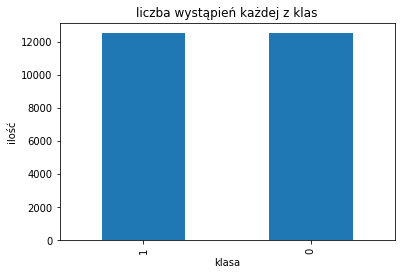

In [3]:
ax = df['Sentiment'].value_counts().plot(kind='bar')
ax.set_title("liczba wystąpień każdej z klas")
ax.set_ylabel("ilość")
ax.set_xlabel("klasa")

In [4]:
# Wypisanie przykladowej recenzji
df.loc[1234, 'SentimentText'] 

'Alright, admit never seen "Rhoda" one two episodes "The Mary Tyler Moore Show." Even though don\'t know anything duo comedic talent, still liked movie lot.<br /><br />Mary goes back work. Rose tries luck comedian. Rhoda struggles photography career. Meredith...what exactly again? three stories follow two hours amusing entertaining way. two long time friends reunite, makes film better. <br /><br />I surprised good writing was. little jokes thrown Mary Rhoda funny. script well put together.<br /><br />I seen Moore Harper movies past years thought good. idea worked well team. actresses share fulfill title movie, never seem let down. (During run movie.) Joie Lenz Marisa Ryan play roles okay nothing great. rest cast like Jonah, Cecile and....everybody else also works well together.<br /><br />Being reunion, would expect fan either show enjoy this. non-fan still enjoyed little get-together. Good story lines character two main characters makes film good. (The newer version MTM theme song doe

### Procesowanie tekstu

#### Czyszczenie 
Jak widac powyzej dane posiadaja znaki specjalne html, ktore nalezy usunac. W celu wyciagniecia z danych tylko slow trzeba usunac rowniez znaki takie jak "." "!" "?" itp.

In [5]:
# Zastapienie znakow spacjami:
df['SentimentText_cleaned'] = df['SentimentText'].apply(lambda x: re.sub("(<br\s*/><br\s*/>)|(\-)|(\/)", " ", x))
df['SentimentText_cleaned'] = df['SentimentText_cleaned'].apply(lambda x: x.replace("_", " "))
# Usuniecie znakow specjalnych:
df['SentimentText_cleaned'] = df['SentimentText_cleaned'].apply(lambda x: re.sub("[\W]+", ' ', x))
# Zamiana wszystkich liter na male:
df['SentimentText_cleaned'] = df['SentimentText_cleaned'].apply(lambda x: x.lower())

In [6]:
#usuniecie cyfr
#df['SentimentText_cleaned'] = df['SentimentText_cleaned'].apply(lambda x: re.sub("\d+", ' ', x))

In [7]:
# przykladowa recencja po wstepnym oczyszczeniu
df.loc[1234, 'SentimentText_cleaned'] 

'alright admit never seen rhoda one two episodes the mary tyler moore show even though don t know anything duo comedic talent still liked movie lot mary goes back work rose tries luck comedian rhoda struggles photography career meredith what exactly again three stories follow two hours amusing entertaining way two long time friends reunite makes film better i surprised good writing was little jokes thrown mary rhoda funny script well put together i seen moore harper movies past years thought good idea worked well team actresses share fulfill title movie never seem let down during run movie joie lenz marisa ryan play roles okay nothing great rest cast like jonah cecile and everybody else also works well together being reunion would expect fan either show enjoy this non fan still enjoyed little get together good story lines character two main characters makes film good the newer version mtm theme song doesn t hurt either '

#### Usuniecie 'stop-words'
Usuniecie bardzo popularnych slow takich jak "i", "jesli", "ona", które nic nie wnosza.

In [10]:
english_stop_words = stopwords.words('english')

In [9]:
# przyklady angielskig 'stop-words':
english_stop_words[::40]

['i', 'that', 'through', 'own', 'ma']

In [11]:
# recenzja po usunieciu 'stop-words':
' '.join([word for word in df.loc[1234, 'SentimentText_cleaned'].split() if word not in english_stop_words])

'alright admit never seen rhoda one two episodes mary tyler moore show even though know anything duo comedic talent still liked movie lot mary goes back work rose tries luck comedian rhoda struggles photography career meredith exactly three stories follow two hours amusing entertaining way two long time friends reunite makes film better surprised good writing little jokes thrown mary rhoda funny script well put together seen moore harper movies past years thought good idea worked well team actresses share fulfill title movie never seem let run movie joie lenz marisa ryan play roles okay nothing great rest cast like jonah cecile everybody else also works well together reunion would expect fan either show enjoy non fan still enjoyed little get together good story lines character two main characters makes film good newer version mtm theme song hurt either'

#### normalizacja (steemming) slow 
Steeming to proces usuniecia ze slowa koncowki fleksyjnej pozostawiajac tylko temat wyrazu.
W celu normalizacji uzyje algorytmu Portera.

In [12]:
porter = PorterStemmer()
def tokenizer_porter(text):
  return [porter.stem(word) for word in text.split()]

In [43]:
' '.join(tokenizer_porter(df.loc[1234, 'SentimentText_cleaned'] ))

'alright admit never seen rhoda one two episod the mari tyler moor show even though don t know anyth duo comed talent still like movi lot mari goe back work rose tri luck comedian rhoda struggl photographi career meredith what exactli again three stori follow two hour amus entertain way two long time friend reunit make film better i surpris good write wa littl joke thrown mari rhoda funni script well put togeth i seen moor harper movi past year thought good idea work well team actress share fulfil titl movi never seem let down dure run movi joie lenz marisa ryan play role okay noth great rest cast like jonah cecil and everybodi els also work well togeth be reunion would expect fan either show enjoy thi non fan still enjoy littl get togeth good stori line charact two main charact make film good the newer version mtm theme song doesn t hurt either'

## Zamian recenzji na wektory oraz testowanie przeprocesowanych danych

In [14]:
# X - wyczyszczone dane, y - kolumna dezycyjna
X_cleaned = df.SentimentText_cleaned
y = df.Sentiment

In [15]:
# Podzial danych na czesc treningowa i testowa
X_cleaned_train, X_cleaned_test, y_cleaned_train, y_cleaned_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)

#### 1. Z uzyciem metody tf-idf (wazeniem czestosci termow - odwrotna czestoscia w tekscie)

##### Wyszukanie najlepszych parametrow oraz sprawdzenie dokladnosci tf-idf i regresji logistycznej z uzyciem metody przeszukiwania siatki.

In [47]:
tfidf = TfidfVectorizer()
lr = LogisticRegression()

param_grid = [
    {
        'vect__ngram_range': [(1,1)],
        'vect__stop_words': [english_stop_words, None],
        'vect__tokenizer': [None, tokenizer_porter],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [1.0, 10.0, 100.0]
    },
    {
        'vect__ngram_range': [(1,1)],
        'vect__stop_words': [english_stop_words, None],
        'vect__tokenizer': [None, tokenizer_porter],
        'vect__use_idf': [None],
        'vect__norm': [None],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [1.0, 10.0, 100.0]
    },
]

tfidf_lr = Pipeline([('vect', tfidf),
                     ('clf', lr)])

In [48]:
gs_tfidf_lr = GridSearchCV(tfidf_lr, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=8)
gs_tfidf_lr.fit(X_cleaned_train, y_cleaned_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 13.6min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed: 18.2min finished
C:\anaconda37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [46]:
# ewaluacja modelu
print(f"Zestaw najlepszych parametrów: {gs_tfidf_lr.best_params_}")
print(f"Dokladnosc sprawdzianu krzyzowego: {gs_tfidf_lr.best_score_}")
clf_tfidf_lr = gs_tfidf_lr.best_estimator_
print(f"Dokladnosc algorytmu na danych testowych: {clf_tfidf_lr.score(X_cleaned_test, y_cleaned_test)}")

AttributeError: 'Pipeline' object has no attribute 'best_params_'

In [86]:
# zapisanie modelu 
dump(clf_tfidf_lr, 'tfidf_lr.joblib')

['tfidf_lr.joblib']

##### Wyszukanie najlepszych parametrow oraz sprawdzenie dokladnosci tf-idf i algorytmu svm z uzyciem metody przeszukiwania siatki.

In [105]:
tfidf = TfidfVectorizer()
svm = SVC()

param_grid = [
    {
        'vect__ngram_range': [(1,1)],
        'vect__stop_words': [english_stop_words, None],
        'clf__kernel': ['linear', 'rbf'],
        'clf__C': [ 0.01, 0.1, 1],
        'clf__gamma': [ 0.01, 0.1, 1]
    },
]

tfidf_svm = Pipeline([('vect', tfidf),
                     #('transform', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True, validate=True)),
                     ('clf', svm)])

In [76]:
gs_tfidf_svm = GridSearchCV(tfidf_svm, param_grid, scoring='accuracy', cv=5, verbose=10, n_jobs=6)
gs_tfidf_svm.fit(X_cleaned_train, y_cleaned_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 26.9min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 35.9min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 44.4min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 51.0min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 63.1min
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed: 77.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [102]:
print(f"Zestaw najlepszych parametrów: {gs_tfidf_svm.best_params_}")
print(f"Dokladnosc sprawdzianu krzyzowego: {gs_tfidf_svm.best_score_}")
clf_tfidf_svm = gs_tfidf_svm.best_estimator_
print(f"Dokladnosc sprawdzianu krzyzowego: {clf_tfidf_svm.score(X_cleaned_test, y_cleaned_test)}")
#Blad - powinno byc dokladnosc na danych testowych

Zestaw najlepszych parametrów: {'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': 'rbf', 'vect__ngram_range': (1, 1)}
Dokladnosc sprawdzianu krzyzowego: 0.8935
Dokladnosc sprawdzianu krzyzowego: 0.8872


In [103]:
# zapisanie modelu 
dump(clf_tfidf_svm, 'tfidf_svm.joblib')

['tfidf_svm.joblib']

##### Wyszukanie najlepszych parametrow oraz sprawdzenie dokladnosci tf-idf i algorytmu k najblizszych sasiadow z uzyciem metody przeszukiwania siatki.

In [16]:
tfidf = TfidfVectorizer()
knn = KNeighborsClassifier()

param_grid = [
    {
        'vect__ngram_range': [(1,1)],
        'vect__stop_words': [english_stop_words, None],
        'vect__tokenizer': [None, tokenizer_porter],
        'clf__n_neighbors': [3, 5, 7]
    },
]

tfidf_knn = Pipeline([('vect', tfidf),
                      ('transform', FunctionTransformer(lambda x: x.todense(), accept_sparse=True, validate=True)),
                      ('clf', knn)])

In [19]:
gs_tfidf_knn = GridSearchCV(tfidf_knn, param_grid, scoring='accuracy', cv=5, verbose=10, n_jobs=10)
gs_tfidf_knn.fit(X_cleaned_train[:5000], y_cleaned_train[:5000])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 12.1min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 17.2min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 18.8min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 28.7min
[Parallel(n_jobs=10)]: Done  48 out of  60 | elapsed: 30.3min remaining:  7.6min
[Parallel(n_jobs=10)]: Done  55 out of  60 | elapsed: 35.3min remaining:  3.2min
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed: 35.5min finished
C:\anaconda37\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', "it'", 'onc', 'onli', 'ourselv', "she'", "should'v", 'themselv', 'thi', 'veri', 'wa', 'whi', "you'r", "you'v", 'yourselv'] not in

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [20]:
print(f"Zestaw najlepszych parametrów: {gs_tfidf_knn.best_params_}")
print(f"Dokladnosc sprawdzianu krzyzowego: {gs_tfidf_knn.best_score_}")
clf_tfidf_knn = gs_tfidf_knn.best_estimator_
print(f"Dokladnosc sprawdzianu krzyzowego: {clf_tfidf_knn.score(X_cleaned_test, y_cleaned_test)}") 
#Blad - powinno byc dokladnosc na danych testowych

Zestaw najlepszych parametrów: {'clf__n_neighbors': 7, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'f

#### 2. Z uzyciem metody count vectorizer

##### Wyszukanie najlepszych parametrow oraz sprawdzenie dokladnosci count vectorizer i regresji logistycznej z uzyciem metody przeszukiwania siatki.

In [23]:
cv = CountVectorizer()
lr = LogisticRegression()

param_grid = [
    {
        'vect__ngram_range': [(1,1), (2,2)],
        'vect__stop_words': [english_stop_words, None],
        'vect__tokenizer': [None, tokenizer_porter],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [1.0, 10.0, 100.0]
    },
]

cv_lr = Pipeline([('vect', cv),
                     ('clf', lr)])

In [24]:
gs_cv_lr = GridSearchCV(cv_lr, param_grid, scoring='accuracy', cv=5, verbose=10, n_jobs=8)
gs_cv_lr.fit(X_cleaned_train, y_cleaned_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   13.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  7.1min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  8.3min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  9.7min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 11.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 12.5min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed: 14.3min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 15.7min
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [26]:
# ewaluacja modelu
print(f"Zestaw najlepszych parametrów: {gs_cv_lr.best_params_}")
print(f"Dokladnosc sprawdzianu krzyzowego: {gs_cv_lr.best_score_}")
clf_cv_lr = gs_cv_lr.best_estimator_
print(f"Dokladnosc na danych testowych: {clf_cv_lr.score(X_cleaned_test, y_cleaned_test)}")

Zestaw najlepszych parametrów: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': None}
Dokladnosc sprawdzianu krzyzowego: 0.8777
Dokladnosc na danych testowych: 0.8758


In [27]:
# zapisanie modelu 
dump(clf_cv_lr, 'cv_lr.joblib')

['cv_lr.joblib']

##### Wnioski

Najlepiej sprawdzila sie regresja logistyczna oraz maszyna wektorow nosnych. Oba w polaczeniu z algorytmem tf-idf maja dokladnosc bliska 89%. Regresja logistyczna z metoda counter vectorizer osiagnela okolo 87.5% a k najblizszych sasiadow (wyuczony jedynie na fragmencie danych z powodu problemow z pamiecia) ma okolo 74% dokladnosci. 

Aby wybrac najlepszy model sprawdze ktory z dwoch najlepszych jest szybszy.

In [58]:
t1 = datetime.datetime.now()
y_pred_lr = clf_tfidf_lr.predict(X_cleaned_test)
t2 = datetime.datetime.now()
lr_time = t2-t1

In [59]:
t1 = datetime.datetime.now()
y_pred_svm = clf_tfidf_svm.predict(X_cleaned_test)
t2 = datetime.datetime.now()
svm_time = t2-t1

In [66]:
print(f"Czas predykcji {X_cleaned_test.shape[0]} probek przez regresje logistyczna: {lr_time}")
print(f"Czas predykcji {X_cleaned_test.shape[0]} probek przez maszyne wektorow nosnych: {svm_time}")

Czas predykcji 5000 probek przez regresje logistyczna: 0:00:00.490700
Czas predykcji 5000 probek przez maszyne wektorow nosnych: 0:00:55.090658


Jak widac regresja logistyczna jest znacznie szybsza

In [69]:
cm_lr = confusion_matrix(y_pred_lr, y_cleaned_test)
cm_svm = confusion_matrix(y_pred_svm, y_cleaned_test)

In [68]:
confusion_matrix(y_pred_svm, y_cleaned_test)

array([[2171,  252],
       [ 312, 2265]], dtype=int64)

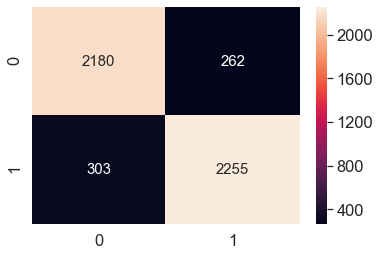

In [81]:
# macierz omylek dla regresji logistycznej
sn.set(font_scale=1.5) # for label size
sn.heatmap(cm_lr, annot=True, annot_kws={"size": 15}, fmt='g') # font size
plt.show()

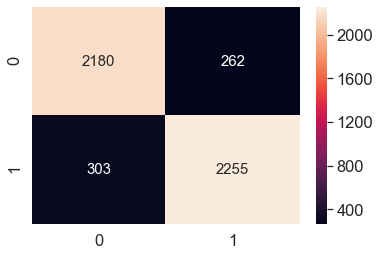

In [82]:
# macierz omylek dla maszyny wektorow nosnych
sn.set(font_scale=1.5) # for label size
sn.heatmap(cm_lr, annot=True, annot_kws={"size": 15}, fmt='g') # font size
plt.show()

#### Najlepszym algorytmem jest regresja 